In [1]:
# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(0)
os.environ['CUDA_VISIBLE_DEVICES'] = ''

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(2)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(24)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(26)

# 5. Configure a new global `tensorflow` session
#from keras import backend as K

from tensorflow.python.keras import backend as K

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)


import os
import cv2
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import os
from keras.models import Sequential, load_model
from tensorflow.keras.models import load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.utils import np_utils
from keras.datasets import mnist
from keras.models import Sequential
from keras.applications.densenet import DenseNet121 as DenseNet121
from sklearn import preprocessing  #用來標準化刻度

#import matplotlib.pyplot as plt


cxr=pd.read_csv("cxr_control_mutli_dead_v2_single.csv")
count=0
train_x = [] 
test_x = [] 
train_y = [] 
test_y = [] 

for index, row in cxr.iterrows():
    if count<13751:
            img = cv2.imread("cxr_control_v2_mutli_dead" + "/" + row["dicom_id"]+".jpg")
         #  img = cv2.resize(img, (64, 64)) 
            train_x.append(img)
            train_y.append(row["eventV3"])
            count=count+1
    else :
        img = cv2.imread("cxr_control_v2_mutli_dead" + "/" + row["dicom_id"]+".jpg")
        # img = cv2.resize(img, (64, 64)) 
        test_x.append(img)
        test_y.append(row["eventV3"])
        count=count+1

train_x=np.array(train_x)
test_x=np.array(test_x)

train_y=np.array(train_y)
test_y=np.array(test_y)

#train_x = train_x.reshape(7305, 256, 256, 3)
#test_x = test_x.reshape(1502, 256, 256, 3)

train_x=train_x/256
test_x=test_x/256

print(train_x.shape)
print(test_x.shape)


(13751, 256, 256, 3)
(1667, 256, 256, 3)


In [2]:
train_x_temp=np.concatenate((train_x[:5000], train_x[-5582:]))
train_y_temp=np.concatenate((train_y[:5000], train_y[-5582:]))

print(train_x_temp.shape)
print(train_y_temp.shape)

print(train_y.shape)
print(np.sum(train_y))
print(train_y_temp)
print(np.sum(train_y_temp))

(10582, 256, 256, 3)
(10582,)
(13751,)
8169
[0 0 0 ... 1 1 1]
5582


In [3]:
print(test_y.shape)
print(np.sum(test_y))
print(test_y)
print(np.sum(test_y))

(1667,)
247
[0 0 0 ... 1 1 1]
247


In [12]:
from tensorflow.keras import layers, models, preprocessing
from keras.layers import Dense, LSTM, BatchNormalization ,MaxPool2D

class_weight={0:1,1:3}

model = Sequential()
model.add(Conv2D(128, (8, 8), strides=2, input_shape=(256, 256, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
#model.add(Dropout(0.3))

model.add(Conv2D(128, (4, 4), strides=2, activation='relu'))
model.add(BatchNormalization())
#model.add(Dropout(0.3))

model.add(Conv2D(128, (2, 2), strides=2, activation='relu'))
model.add(BatchNormalization())
#model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(units=256, activation="relu"))
model.add(Dense(units=1, activation="sigmoid"))

model.summary()

model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy']) #binary_crossentropy categorical_crossentropy

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 125, 125, 128)     24704     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 128)       0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 62, 62, 128)       512       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 30, 128)       262272    
_________________________________________________________________
batch_normalization_4 (Batch (None, 30, 30, 128)       512       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 15, 15, 128)       65664     
_________________________________________________________________
batch_normalization_5 (Batch (None, 15, 15, 128)      

In [13]:
train_history = model.fit(x=train_x_temp, y=train_y_temp, validation_split=0.2, epochs=10, batch_size=32, verbose=2,class_weight=class_weight)#
#train_history = model.fit(x=train_x, y=train_y, validation_split=0.2, epochs=10, batch_size=32, verbose=2,class_weight=class_weight)


Epoch 1/10
265/265 - 18s - loss: 1.8520 - accuracy: 0.4451 - val_loss: 0.3927 - val_accuracy: 0.9131
Epoch 2/10
265/265 - 12s - loss: 1.1298 - accuracy: 0.5386 - val_loss: 0.5368 - val_accuracy: 0.7463
Epoch 3/10
265/265 - 12s - loss: 1.0706 - accuracy: 0.5486 - val_loss: 0.4789 - val_accuracy: 0.9258
Epoch 4/10
265/265 - 12s - loss: 1.0441 - accuracy: 0.5703 - val_loss: 0.4295 - val_accuracy: 0.8706
Epoch 5/10
265/265 - 12s - loss: 1.0470 - accuracy: 0.5810 - val_loss: 1.2268 - val_accuracy: 0.9103
Epoch 6/10
265/265 - 12s - loss: 1.0391 - accuracy: 0.5816 - val_loss: 0.3462 - val_accuracy: 0.8819
Epoch 7/10
265/265 - 12s - loss: 0.9836 - accuracy: 0.6047 - val_loss: 0.4070 - val_accuracy: 0.8692
Epoch 8/10
265/265 - 12s - loss: 0.9680 - accuracy: 0.6172 - val_loss: 0.7759 - val_accuracy: 0.6982
Epoch 9/10
265/265 - 12s - loss: 0.9749 - accuracy: 0.6272 - val_loss: 0.2880 - val_accuracy: 0.9136
Epoch 10/10
265/265 - 12s - loss: 0.9437 - accuracy: 0.6345 - val_loss: 0.3992 - val_accura

In [14]:
neur_test_y_predicted = model.predict(test_x)
predict_test=[]
for i in range(neur_test_y_predicted.shape[0]): 
    if neur_test_y_predicted[i]>0.5:
        predict_test.append(1)
    else:
        predict_test.append(0)
predict_test = np.array(predict_test)

#print(predict_test)

from sklearn.metrics import accuracy_score, f1_score,precision_score,recall_score,confusion_matrix

cm1 = confusion_matrix(test_y,predict_test)

sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR

#print('Precision:',precision_score(y_test_1, predict_test))
#print('Recall:', recall_score(y_test_1, predict_test))
#print('f1-score: %f' % f1_score(y_test_1, predict_test))
print('Accuracy: %f' % accuracy_score(test_y, predict_test))
print('Sensitivity : %0.2f' % sensitivity )
print('Specificity :%0.2f' % specificity)

pd.crosstab(test_y,predict_test,rownames=['label'],colnames=['predict'])


Accuracy: 0.483503
Sensitivity : 0.83
Specificity :0.42


predict,0,1
label,,
0,602,818
1,43,204


In [17]:
pd_neur_test_y_predicted_dead=pd.DataFrame(neur_test_y_predicted)
pd_neur_test_y_predicted_dead.to_csv('neur_test1_dead.csv', index=False)

In [18]:
pd_neur_test_y_predicted_dead[-247:]

,0
1420,0.757571
1421,0.775581
1422,0.553296
1423,0.795225
1424,0.652820
...,...
1662,0.814986
1663,0.884084
1664,0.610481
1665,0.839305


<Figure size 432x288 with 0 Axes>

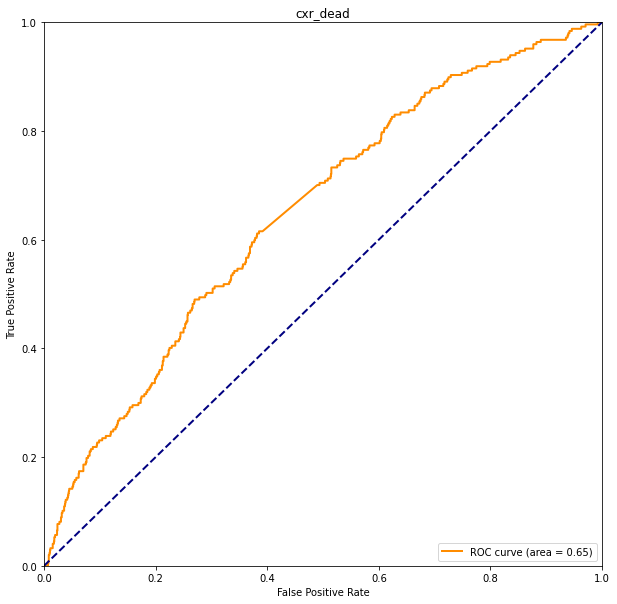

In [9]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt   # plotting
# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(test_y, neur_test_y_predicted) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('cxr_dead')
plt.legend(loc="lower right")

plt.show()


In [10]:
neur_train_y_predicted = model.predict(train_x_temp)
predict_train=[]
for i in range(neur_train_y_predicted.shape[0]): 
    if neur_train_y_predicted[i]>0.5:
        predict_train.append(1)
    else:
        predict_train.append(0)
predict_train = np.array(predict_train)

#print(predict_train)

from sklearn.metrics import accuracy_score, f1_score,precision_score,recall_score,confusion_matrix

cm1 = confusion_matrix(train_y_temp,predict_train)

sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR

#print('Precision:',precision_score(y_test_1, predict_test))
#print('Recall:', recall_score(y_test_1, predict_test))
#print('f1-score: %f' % f1_score(y_test_1, predict_test))
print('Accuracy: %f' % accuracy_score(train_y_temp, predict_train))
print('Sensitivity : %0.2f' % sensitivity )
print('Specificity :%0.2f' % specificity)

pd.crosstab(train_y_temp,predict_train,rownames=['label'],colnames=['predict'])


Accuracy: 0.719335
Sensitivity : 0.73
Specificity :0.71


predict,0,1
label,,
0,3550,1450
1,1520,4062


<Figure size 432x288 with 0 Axes>

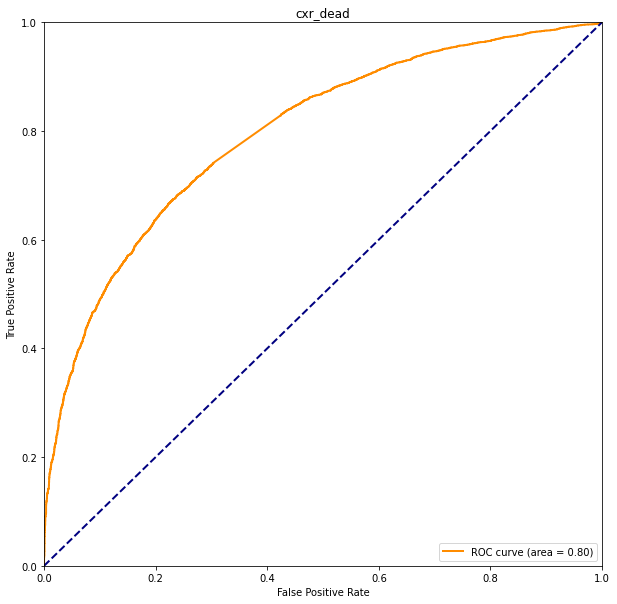

In [11]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt   # plotting
# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(train_y_temp, neur_train_y_predicted) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('cxr_dead')
plt.legend(loc="lower right")

plt.show()
